In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import math
from PIL import Image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


20.000 images 224px x 224px
    90% train - 18.000
    5% dev - 1.000
    5% test - 1.000

In [63]:
def load_data(seed):
    nTotal = 20000
    
    X = np.zeros((nTotal, 4096))
    Y = np.zeros((nTotal, 1))
    count = 0
    for dirname, _, filenames in os.walk('Datasets'):
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename)).resize((64, 64))
            data = np.asarray(image, dtype='float64').reshape(1, -1)

            data = data / 255
            
            X[count] = data
            if count == 0:
                print("Data shape ", data.shape)
                print(data)
                plt.imshow(image)
            if(count < nTotal / 2):
                Y[count] = 0
            elif(count < nTotal):
                Y[count] = 1
            count += 1

    np.random.seed(seed)

    indices = list(np.random.permutation(nTotal))
    X = X[indices]
    Y = Y[indices]

    nTrain = int(nTotal * 0.9)
    nDev = int(nTotal * 0.05) + nTrain
    nTest = int(nTotal * 0.05) + nTrain + nDev

    trainX = X[: nTrain]
    trainY = Y[: nTrain]
    
    devX = X[nTrain : nDev]
    devY = Y[nTrain : nDev]

    testX = X[nDev : nTest]
    testY = Y[nDev : nTest]
    
    return trainX.T, trainY.T, devX.T, devY.T, testX.T, testY.T

Data shape  (1, 4096)
[[0.60784314 0.6        0.6        ... 0.46666667 0.49411765 0.50588235]]


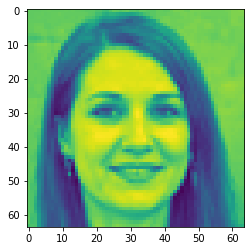

In [64]:
trainX, trainY, devX, devY, testX, testY = load_data(1)

dnn_utils_v2

In [65]:
print(type(trainX))
print(trainX.dtype)
print("Data shape TrainX", trainX.shape)
print("Data shape TrainY", trainY.shape)
print(trainX[0])

<class 'numpy.ndarray'>
float64
Data shape TrainX (4096, 18000)
Data shape TrainY (1, 18000)
[0.45098039 0.25882353 0.36470588 ... 0.5254902  0.41568627 0.67843137]


In [66]:
def verifyDataset(i):
    plt.imshow(trainX[:,i].reshape((64,64)))
    print(trainY[0,i])

1.0


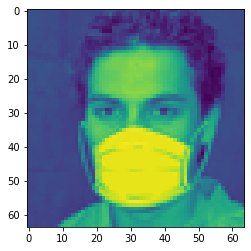

In [67]:
verifyDataset(1)

In [68]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


He initialization

In [69]:
# For ReLU
def initialize_parameters_he(layers_dims, seed):
    np.random.seed(seed)
    parameters = {}
    # Number of layers
    L = len(layers_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1], dtype='float64')
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1), dtype='float64')
        
    return parameters

Forward Propagation

In [70]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.
    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache


def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss)    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """

    caches = []
    A = X
    # number of layers in the neural network
    L = len(parameters) // 2
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A

        Z, linear_cache = linear_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)])
        A, activation_cache = relu(Z)
        cache = (linear_cache, activation_cache)
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Last layer
    Z, linear_cache = linear_forward(A, parameters['W' + str(L)], parameters['b' + str(L)])
    AL, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)
    caches.append(cache)

    return AL, caches

Cost

In [71]:
def compute_cost(AL, Y, epsil):
    """
    Implement the cost function.
    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    
    # Compute loss from aL and y.
    # cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = (-1 / m) * np.sum(Y* np.log(AL + epsil) + (1 - Y) * np.log(1 + epsil - AL))
    cost = np.squeeze(cost)
    
    return cost

Backward Propagation

In [72]:
def linear_backward(dZ, A_prev, W):
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def backward_propagation(AL, Y, caches, epsil):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    linear_cache, activation_cache = caches[L-1]
    A_prev, W, b = linear_cache
    Z = activation_cache

    AL += epsil

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dA_curr = dAL

    dZ = sigmoid_backward(dA_curr, Z)

    dA_prev, dW, db = linear_backward(dZ, A_prev, W)

    grads["dW" + str(L)] = dW 
    grads["db" + str(L)] = db

    for l in reversed(range(L-1)):
        linear_cache, activation_cache = caches[l]
        A_prev, W, b = linear_cache
        Z = activation_cache
        
        dA_curr = dA_prev

        dZ = relu_backward(dA_curr, Z)

        dA_prev, dW, db = linear_backward(dZ, A_prev, W)

        grads["dW" + str(l + 1)] = dW 
        grads["db" + str(l + 1)] = db

    return grads

Update Parameters

In [73]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]        

    return parameters

In [74]:
def random_mini_batches(X, Y, mini_batch_size = 1024, seed = 0):
    m = X.shape[1]
    mini_batches = []

    np.random.seed(seed)
    indices = list(np.random.permutation(m))
    shuffled_X = X[:, indices]
    shuffled_Y = Y[:, indices].reshape((1, m))

    complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * complete_minibatches : m]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * complete_minibatches : m]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [75]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
        
    # Forward propagation
    AL, caches = forward_propagation(X, parameters)

    print("Accurracy: ", np.sum(np.rint(AL) == y) / m)

    return X, AL

In [96]:
def model(X, Y, learning_rate = 0.01, num_epochs = 15000, mini_batch_size = 1024, eps = 1e-15, seed = 1):
    # Define neurons per layer
    m = X.shape[1]
    layers_dims = [X.shape[0], 128, 64, 1]
    np.random.seed(seed)
    mini_batches = []
    costs = []
    costs_dev = []

    # Initialize parameters dictionary
    parameters = initialize_parameters_he(layers_dims, seed)
    predict(X, Y, parameters)

    for i in range(num_epochs):
        seed = seed + 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch

            AL, caches = forward_propagation(mini_batch_X, parameters)

            cost_total += compute_cost(AL, mini_batch_Y, eps)

            grads = backward_propagation(AL, mini_batch_Y, caches, eps)

            parameters = update_parameters(parameters, grads, learning_rate)
            
        cost = cost_total / len(mini_batches)
        costs.append(cost)

        AL_dev, caches = forward_propagation(devX, parameters)
        cost_dev = compute_cost(AL_dev, devY, eps)
        costs_dev.append(cost_dev)
        

        if i % 3 == 0:
            print("Cost after epoch %i: %f" %(i, cost))
            predict(X, Y, parameters)
    
    X, AL = predict(X, Y, parameters)

    plt.plot(np.squeeze(costs), label = 'Test cost')
    plt.plot(np.squeeze(costs_dev), label = 'Dev cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend()
    plt.show()

    return parameters, X, AL

Accurracy:  0.4976111111111111
Cost after epoch 0: 0.506953
Accurracy:  0.8651111111111112
Cost after epoch 3: 0.072782
Accurracy:  0.9926666666666667
Cost after epoch 6: 0.035224
Accurracy:  0.9969444444444444
Cost after epoch 9: 0.022286
Accurracy:  0.9976666666666667
Cost after epoch 12: 0.016520
Accurracy:  0.9981666666666666
Cost after epoch 15: 0.012978
Accurracy:  0.9985
Cost after epoch 18: 0.010682
Accurracy:  0.9987777777777778
Cost after epoch 21: 0.009278
Accurracy:  0.9987777777777778
Cost after epoch 24: 0.008053
Accurracy:  0.9988888888888889
Cost after epoch 27: 0.007130
Accurracy:  0.999
Cost after epoch 30: 0.006581
Accurracy:  0.999
Cost after epoch 33: 0.005982
Accurracy:  0.9990555555555556
Cost after epoch 36: 0.005680
Accurracy:  0.9991666666666666
Cost after epoch 39: 0.004955
Accurracy:  0.9991666666666666
Cost after epoch 42: 0.004575
Accurracy:  0.9992222222222222
Cost after epoch 45: 0.004314
Accurracy:  0.9995
Cost after epoch 48: 0.004089
Accurracy:  0.999

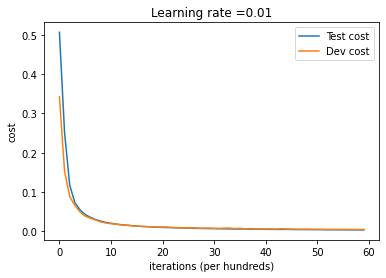

In [98]:
parametersModel, X, AL = model(trainX, trainY, 0.01, 60, 512, 1e-15, 1)

In [78]:
def verifyTrain(i):
    acc = round(AL[0,i] * 100, 2)
    plt.title(str(acc) + "% has mask")
    plt.imshow(X[:,i].reshape((64,64)))
    plt.show()

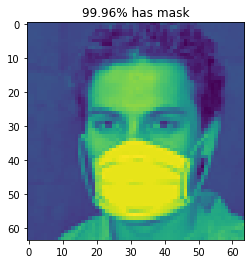

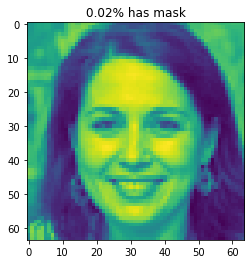

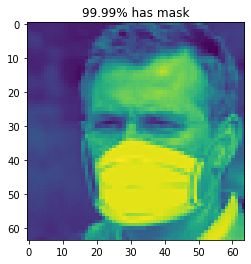

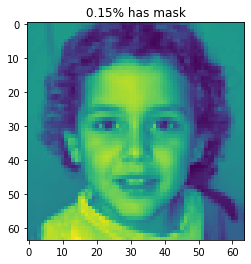

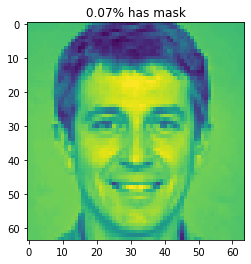

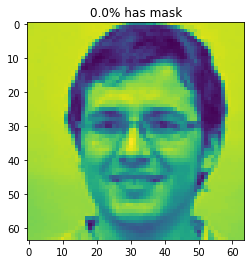

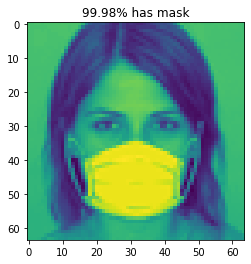

In [79]:
verifyTrain(1)
verifyTrain(100)
verifyTrain(200)
verifyTrain(300)
verifyTrain(400)
verifyTrain(10000)
verifyTrain(17999)

In [80]:
def testAccuracy():
    predict(testX, testY, parametersModel)

def devAccuracy():
    predict(devX, devY, parametersModel)

In [81]:
testAccuracy()
devAccuracy()

Accurracy:  1.0
Accurracy:  0.998
